In [12]:


import os, cv2, numpy as np, tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm

# ---- Directories ----
RAW_DIR = "/content/drive/MyDrive/Assignment2/Picture"
NEW_DIR = "/content/drive/MyDrive/Assignment2/DoubledDataset"

# Create augmenter
augmenter = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    brightness_range=[0.9, 1.1],
    horizontal_flip=True,
    width_shift_range=0.05,
    height_shift_range=0.05,
    fill_mode='nearest'
)

students = [s for s in os.listdir(RAW_DIR) if os.path.isdir(os.path.join(RAW_DIR, s))]
print("Student classes found:", students)

total = 0
per_student = {}

# ---- Process each class ----
for student in students:
    src_folder = os.path.join(RAW_DIR, student)
    save_folder = os.path.join(NEW_DIR, student)
    os.makedirs(save_folder, exist_ok=True)

    images = [img for img in os.listdir(src_folder) if img.lower().endswith(('.jpg','.png','.jpeg'))]
    per_student[student] = len(images) * 2  # expected doubled
    total += len(images) * 2

    for img in tqdm(images, desc=f"Copying originals {student}"):
        img_path = os.path.join(src_folder, img)

        # Load original
        image = tf.keras.utils.load_img(img_path, target_size=(227,227))
        image = tf.keras.utils.img_to_array(image)
        image = image.reshape(1, *image.shape)

        # Save original copy
        orig_name = img.replace(" ", "_")
        cv2.imwrite(os.path.join(save_folder, orig_name), image[0])

        # Generate and save 1 augmented copy
        next(augmenter.flow(image, save_to_dir=save_folder, save_prefix="aug", save_format="jpg"))

print("\nDataset creation complete!")
print("Total images in new dataset folder (expected):", total)
print("Expected per class:", per_student)


Student classes found: ['Rahul', 'Era', 'Apurbo', 'Sagor']


Copying originals Sagor: 100%|██████████| 32/32 [00:01<00:00, 17.03it/s]


Dataset creation complete!
Total images in new dataset folder (expected): 200
Expected per class: {'Rahul': 50, 'Era': 40, 'Apurbo': 46, 'Sagor': 64}


In [13]:
import os

check_total = 0
real_counts = {}

DATA_DIR = "/content/drive/MyDrive/Assignment2/DoubledDataset"

for student in os.listdir(DATA_DIR):
    folder = os.path.join(DATA_DIR, student)
    if os.path.isdir(folder):
        c = len(os.listdir(folder))
        real_counts[student] = c
        check_total += c

print("Actual images per class:", real_counts)
print("Actual total dataset images:", check_total)


Actual images per class: {'Rahul': 50, 'Era': 40, 'Apurbo': 46, 'Sagor': 63}
Actual total dataset images: 199


Student classes: ['Rahul', 'Era', 'Apurbo', 'Sagor']


Loading Sagor: 100%|██████████| 63/63 [00:00<00:00, 95.49it/s] 



Total training images: 199
Input tensor shape: (199, 227, 227, 3)
Label order: [np.str_('Apurbo'), np.str_('Era'), np.str_('Rahul'), np.str_('Sagor')]
Encoder saved at: /content/drive/MyDrive/Assignment2/label_encoder.pkl
Train set: (159, 227, 227, 3)
Test set: (40, 227, 227, 3)
Epoch 1/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 15s 283ms/step - accuracy: 0.2644 - loss: 2.6227 - val_accuracy: 0.3250 - val_loss: 2.4779
Epoch 2/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.2686 - loss: 2.4678 - val_accuracy: 0.3250 - val_loss: 2.3717
Epoch 3/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.2753 - loss: 2.3542 - val_accuracy: 0.3250 - val_loss: 2.2342
Epoch 4/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.3859 - loss: 2.2024 - val_accuracy: 0.4750 - val_loss: 1.9263
Epoch 5/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.4636 - loss: 2.0381 - val_accuracy: 0.5500 - val_loss: 1.7183
Epoch 6/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.5643 - loss: 1.57

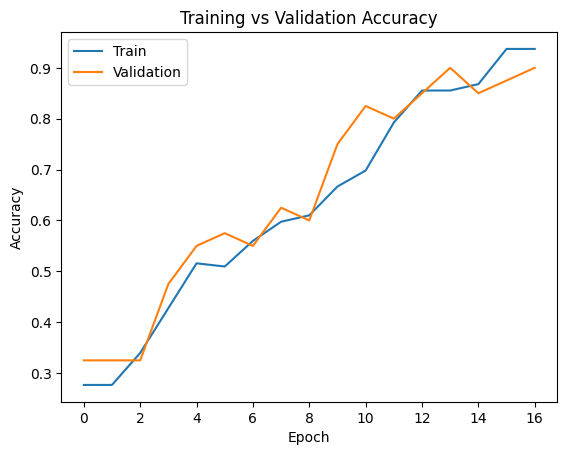

In [14]:
import os, cv2, numpy as np, tensorflow as tf
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd, pickle

# ---- Load dataset from doubled folder ----
DATA_DIR = "/content/drive/MyDrive/Assignment2/DoubledDataset"
IMG_SIZE = 227

data = []
labels = []

students = [s for s in os.listdir(DATA_DIR) if os.path.isdir(os.path.join(DATA_DIR, s))]
print("Student classes:", students)

for student in students:
    folder = os.path.join(DATA_DIR, student)
    for img in tqdm(os.listdir(folder), desc=f"Loading {student}"):
        img_array = cv2.imread(os.path.join(folder, img))
        if img_array is None:
            continue
        img_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
        img_array = img_array / 255.0
        data.append(img_array)
        labels.append(student)

data = np.array(data)
labels = np.array(labels)

print("\nTotal training images:", len(data))
print("Input tensor shape:", data.shape)

# ---- Encode labels ----
encoder = LabelEncoder()
y = encoder.fit_transform(labels)
print("Label order:", list(encoder.classes_))

# Save encoder for later VS Code inference
ENC_PATH = "/content/drive/MyDrive/Assignment2/label_encoder.pkl"
with open(ENC_PATH, "wb") as f:
    pickle.dump(encoder, f)
print("Encoder saved at:", ENC_PATH)

# ---- Stratified train/test split ----
X_train, X_test, y_train, y_test = train_test_split(
    data, y, test_size=0.2, random_state=42, stratify=y
)

print("Train set:", X_train.shape)
print("Test set:", X_test.shape)

# ---- Build AlexNet with smaller FC head ----
def build_alexnet(num_classes):
    return models.Sequential([
        layers.Input(shape=(227,227,3)),
        layers.Conv2D(96, (11,11), strides=4, activation='relu'),
        layers.MaxPooling2D((3,3), strides=2),
        layers.Conv2D(256, (5,5), padding='same', activation='relu'),
        layers.MaxPooling2D((3,3), strides=2),
        layers.Conv2D(384, (3,3), padding='same', activation='relu'),
        layers.Conv2D(384, (3,3), padding='same', activation='relu'),
        layers.Conv2D(256, (3,3), padding='same', activation='relu'),
        layers.MaxPooling2D((3,3), strides=2),
        layers.Flatten(),
        layers.Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.0005)),
        layers.Dropout(0.4),
        layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.0005)),
        layers.Dropout(0.4),
        layers.Dense(num_classes, activation='softmax')
    ])

model = build_alexnet(len(encoder.classes_))

# Freeze first conv layer to avoid relearning edges from scratch
model.layers[1].trainable = False

# ---- Compile ----
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# ---- Early stopping ----
early = EarlyStopping(
    monitor='val_accuracy',
    patience=3,
    restore_best_weights=True,
    mode='max'
)

# ---- Train ----
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=25,
    batch_size=6,
    callbacks=[early]
)

# ---- Save model ----
MODEL_SAVE = "/content/drive/MyDrive/Assignment2/alexnet_attendance.keras"
model.save(MODEL_SAVE)
print("Model saved at:", MODEL_SAVE)

# ---- Evaluate ----
loss, acc = model.evaluate(X_test, y_test)
print("Final test accuracy:", acc)

# ---- Save attendance from test predictions ----
preds = model.predict(X_test)
names = encoder.inverse_transform(np.argmax(preds, axis=1))

attendance = []
for name in names:
    attendance.append([name, datetime.now().strftime("%Y-%m-%d %H:%M:%S")])

df = pd.DataFrame(attendance, columns=["Name","Time"])
CSV_SAVE = "/content/drive/MyDrive/Assignment2/attendance_demo.csv"
df.to_csv(CSV_SAVE, index=False)
print("Attendance CSV saved at:", CSV_SAVE)

# ---- Plot accuracy curve ----
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Training vs Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["Train","Validation"])
plt.show()
